## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Целевой признак ушел клиент - `1` , не ушел - `0` обозначим как **`loss`**

## Описание данных

Данные состоят из файлов, полученных из разных источников:

    contract.csv — информация о договоре;
    personal.csv — персональные данные клиента;
    internet.csv — информация об интернет-услугах;
    phone.csv — информация об услугах телефонии.



In [1]:
#!pip install catboost

import pandas as pd
import numpy as np 
import re
import matplotlib.pyplot as plt 
import os

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from sklearn.preprocessing import OrdinalEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix # матрица ошибок
from sklearn.metrics import recall_score # Полнота -доля истинно положительных классификаций
from sklearn.metrics import precision_score #Точностью (precision) доля правильных ответов модели в пределах клаcса

from catboost import CatBoostClassifier

from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler


#Уберем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    #локальный адрес
    df_contract = pd.read_csv(os.path.abspath(os.path.curdir)+'\\final_provider\\contract.csv')
    df_personal = pd.read_csv(os.path.abspath(os.path.curdir)+'\\final_provider\\personal.csv')
    df_internet = pd.read_csv(os.path.abspath(os.path.curdir)+'\\final_provider\\internet.csv')
    df_phone = pd.read_csv(os.path.abspath(os.path.curdir)+'\\final_provider\\phone.csv')
except:
    #'адрес в тренажере'
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
def info_df(df):
    """
    Функция предназначена для получения информации о DataFrame, которая включает в себя:
    1. общую информацию о данных
    2. переименовывает столбцы в соответствии со стилем
    """
    
    column=[] #список для названия столбцов
    column.append(df.columns[0])#индекс переименовывать не будем
    
    for i in range(1,len(df.columns)):
        column.append(camel_snake(df.columns[i]))
    
    #print (column)

    rename_column=dict(zip(df.columns, column))
    #print(rename_column)
    df.rename(columns=rename_column, inplace=True)
    #display(df.describe())
    display(df.info())
    return df

In [4]:
def camel_snake (n,separator='_'):
    """
    Функция для перевода названия столбцов из "верблюжего" в "змеиный"
    для работы функции нужен модуль "re"
    """
    
    list_string=re.sub(r'([A-Y])',r' \1',n).split()
    string=separator.join(list_string)
    
    return string.lower()

In [5]:
def value_counts_df(df):
    """
    Функция предназначена для получения уникальных значений в столбцах DataFrame
    """
    
        
    for i in range(1,len(df.columns)):
        
        print('Столбец',df.columns[i])
        display(df[df.columns[i]].value_counts())
        
    return

In [6]:
def ROC (target_test, predictions):
    """
    Функция построения ROC-AUC кривой
    """
    print('ROC-AUC score', roc_auc_score(target_test, predictions))
    
    fpr, tpr, thresholds = roc_curve(target_test, predictions)
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--') # для случайной модели
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
    return

In [7]:
def upsample(features, target, repeat):
    """
    Функция масштабирования признаков
    """
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

### Информация о договоре `contract.csv`

In [8]:
info_df(df_contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


**Характеристики таблицы `df_contract`** 

`customerID`- Код клиента          
`begin_date`- Дата начала договора         
`end_date` - Дата окончания договора         
`type` - Тип оплаты (месячная, годовая)             
`paperless_billing`-Безбумажное выставление счетов   
`payment_method`- Метод оплаты      
`monthly_charges`- Ежемесячные платежи    
`total_charges` - Всего начислений      

In [9]:
value_counts_df(df_contract)

Столбец begin_date


2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: begin_date, Length: 77, dtype: int64

Столбец end_date


No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

Столбец type


Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

Столбец paperless_billing


Yes    4171
No     2872
Name: paperless_billing, dtype: int64

Столбец payment_method


Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

Столбец monthly_charges


20.05     61
19.85     45
19.95     44
19.90     44
20.00     43
          ..
23.65      1
114.70     1
43.65      1
87.80      1
78.70      1
Name: monthly_charges, Length: 1585, dtype: int64

Столбец total_charges


          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: total_charges, Length: 6531, dtype: int64

### Вывод

1. В данных нет пропусков
2. Даты начала и окончания договора нужно перевести в формат даты
3. No в end_date означает, что пользователь продолжает пользоваться услугами можно заменить временем выгрузки т.е (01.02.2020)
4. total_charges надо перевести в числовой тип
5. type, paperless_billing, payment_method используем One Hot Encoding для перевода категориальных признаков 



### Персональные данные клиента `personal.csv`

In [10]:
info_df(df_personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customerID      7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


**Характеристики таблицы `df_personal`** 

`customerID`     - Код клиента    
`gender`         - Пол (муж, жен)     
`senior_citizen` - Пенсионер    
`partner`        - Партнер       
`dependents`     - Иждивенцы  


In [11]:
value_counts_df(df_personal)

Столбец gender


Male      3555
Female    3488
Name: gender, dtype: int64

Столбец senior_citizen


0    5901
1    1142
Name: senior_citizen, dtype: int64

Столбец partner


No     3641
Yes    3402
Name: partner, dtype: int64

Столбец dependents


No     4933
Yes    2110
Name: dependents, dtype: int64

### Вывод

1. В данных нет пропусков
2. gender, partner, dependents используем One Hot Encoding для перевода категориальных признаков 



### Информация об интернет-услугах `internet.csv`

In [12]:
info_df(df_internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customerID         5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_t_v      5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


**Характеристики таблицы `df_internet`** 

`customerID`       - Код клиента    
`internet_service` - Интернет-сервис  
`online_security`  - Блокировка небезопасных сайтов  
`online_backup`    - Облачное хранилище файлов для резервного копирования данных  
`device_protection`- Антивирус   
`tech_support`     - Выделенная линия технической поддержки  
`streaming_t_v`    - Стриминговое телевидение  
`streaming_movies` - Каталог фильмов  


In [13]:
value_counts_df(df_internet)

Столбец internet_service


Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

Столбец online_security


No     3498
Yes    2019
Name: online_security, dtype: int64

Столбец online_backup


No     3088
Yes    2429
Name: online_backup, dtype: int64

Столбец device_protection


No     3095
Yes    2422
Name: device_protection, dtype: int64

Столбец tech_support


No     3473
Yes    2044
Name: tech_support, dtype: int64

Столбец streaming_t_v


No     2810
Yes    2707
Name: streaming_t_v, dtype: int64

Столбец streaming_movies


No     2785
Yes    2732
Name: streaming_movies, dtype: int64

### Вывод

1. В данных нет пропусков
2. Все столбцы, кроме `customerID` кодируем используя One Hot Encoding для перевода категориальных признаков 
3. Количестов строк составляет 5517, что меньше чем в остальных таблицах



### Информация об услугах телефонии `phone.csv`

In [14]:
info_df(df_phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customerID      6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


**Характеристики таблицы `df_phone`** 

`customerID`       - Код клиента    
`multiple_lines` - Несколько линий  


In [15]:
value_counts_df(df_phone)

Столбец multiple_lines


No     3390
Yes    2971
Name: multiple_lines, dtype: int64

### Вывод

1. В данных нет пропусков
2. `multiple_lines` кодируем используя One Hot Encoding для перевода категориальных признаков 
3. Количестов строк составляет 6361, что меньше чем в остальных таблицах



In [16]:
data=[df_contract,df_personal,df_internet,df_phone]
j=1
for df in data:
    print('Таблица=',j)
    display(df[df['customerID']=='2569-WGERO'])
    #print('Таблица=',j, 'customerID=9305-CDSKC')
    display(df[df['customerID']=='9305-CDSKC'])
    j+=1

Таблица= 1


,customerID,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
7037,2569-WGERO,2014-02-01,No,Two year,Yes,Bank transfer (automatic),21.15,1419.4


,customerID,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5


Таблица= 2


,customerID,gender,senior_citizen,partner,dependents
7037,2569-WGERO,Female,0,No,No


,customerID,gender,senior_citizen,partner,dependents
5,9305-CDSKC,Female,0,No,No


Таблица= 3


,customerID,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies


,customerID,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes


Таблица= 4


,customerID,multiple_lines
6356,2569-WGERO,No


,customerID,multiple_lines
3,9305-CDSKC,Yes


## Вопросы

1. Целевой признак - если end_date равен No, можно ли заменить временем выгрузки?
2. Какую метрику надо использовать?
3. На какие значения метрики надо ориентироваться?
4. Какой способ кодирования лучше примениить One-Hot Encoding или Ordinal Encoding ?


## План

1. Изучить данные в файлах - проверить типы, есть ли пропуски, надо ли преобразовывать данные
2. Подготовить данных на основе выводов, полученных на предыдущем шаге
3. Провести исследовательский анализ данных - собрать все в единую таблицу провести вузализацию данных, убрать выбросы
4. Рассмотреть модели классификации и подбрать их параметры
5. Вывод по итогам работы



## Предобработка данных

In [17]:
# Объеденим все в одну таблицу через merge how='outer' или how='left' по столбцу 'customerID'

In [18]:
df_data=df_contract.merge(df_personal,how='left', on='customerID').merge(df_internet,how='left',on='customerID').merge(df_phone,how='left',on='customerID')

In [19]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

In [20]:
display(df_data)

,customerID,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


Проверка уникальных индексов пользователя

In [21]:
df_data['customerID'].is_unique

True

In [22]:
display(df_data.isna().sum()) # подсчёт пропусков

customerID              0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_t_v        1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Добавим целевой признак loss, который будет означать отказался клиент от услуг или нет.
Если значение в столбце end_date равно "No", то значит клиент не ушел и целевой признак равен 0.
Если дата ухода есть, то целевой признак равен 1.

In [23]:
df_data['loss'] = (df_data['end_date'] != 'No').astype(int)
df_data.head()

,customerID,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,loss
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,1


Заменим все значения "No" в end_date на дату выгрузки датасета (01.02.2020)

In [24]:
df_data['end_date'] = df_data['end_date'].replace(['No'], ['2020-02-01'])
display(df_data[df_data['end_date'] == 'No'])

,customerID,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,loss


Переведем end_date и begin_date в формат даты

In [25]:
df_data['begin_date'] = pd.to_datetime(df_data['begin_date'], format='%Y-%m-%d')
df_data['end_date'] = pd.to_datetime(df_data['end_date'], format='%Y-%m-%d')

df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customerID         7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [26]:
# Добавляем метрику время пользования услугами организации
# df_data['total_date']=(df_data.end_date.subtract(df_data.begin_date))
display((df_data.end_date.subtract(df_data.begin_date)).dt.days)
# display((df_data['end_date']-df_data['begin_date']).dt.days)
df_data['total_date']=(df_data['end_date']-df_data['begin_date']).dt.days
display(df_data['total_date'])


0         31
1       1036
2         61
3       1371
4         61
        ... 
7038     730
7039    2191
7040     337
7041     123
7042    2010
Length: 7043, dtype: int64

0         31
1       1036
2         61
3       1371
4         61
        ... 
7038     730
7039    2191
7040     337
7041     123
7042    2010
Name: total_date, Length: 7043, dtype: int64

Переведем total_charges в числовой тип

In [27]:
df_data['total_charges'] = pd.to_numeric(df_data['total_charges'], errors ='coerce')
#df_data['total_charges']=df_data['total_charges'].astype('float')
df_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customerID         7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [28]:
display(df_data.isna().sum()) # подсчёт пропусков

customerID              0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_t_v        1526
streaming_movies     1526
multiple_lines        682
loss                    0
total_date              0
dtype: int64

In [29]:
df_data[df_data['total_charges'].isnull()]

,customerID,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,loss,total_date
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,...,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,...,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,Female,0,...,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0,0


Заполним пропуски 0 т.к подключились в один день

In [30]:
df_data['total_charges']=df_data['total_charges'].fillna(0)

In [31]:
display(df_data.isna().sum()) # подсчёт пропусков

customerID              0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_t_v        1526
streaming_movies     1526
multiple_lines        682
loss                    0
total_date              0
dtype: int64

Установим customerID в качестве индекса

In [32]:
df_data = df_data.set_index('customerID')

In [33]:
info_df(df_data)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5517 non-null   object        
 14

None

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,loss,total_date
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,...,DSL,No,Yes,No,No,No,No,NaN,0,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,...,DSL,Yes,Yes,No,No,No,No,No,1,61
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,...,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1371
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,...,Fiber optic,No,No,No,No,No,No,No,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,Male,0,Yes,...,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,0,730
2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,Yes,...,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0,2191
4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,...,DSL,Yes,No,No,No,No,No,NaN,0,337


Пропуски в остальных категориальных столбцах скорее всего означают отсутсвие услуги, заменим на **No**

In [34]:
data_columns=['internet_service','online_security',
              'online_backup','device_protection',
              'tech_support','streaming_t_v',
              'streaming_movies','multiple_lines']

In [35]:
for i in data_columns:
    df_data[i]=df_data[i].fillna('No')
    

In [36]:
display(df_data.isna().sum()) # подсчёт пропусков

begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_t_v        0
streaming_movies     0
multiple_lines       0
loss                 0
total_date           0
dtype: int64

In [37]:
info_df(df_data)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   object        
 13  online_backup      7043 non-null   object        
 14

None

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,loss,total_date
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,...,DSL,No,Yes,No,No,No,No,No,0,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,...,DSL,Yes,Yes,No,No,No,No,No,1,61
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,...,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,...,Fiber optic,No,No,No,No,No,No,No,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,Male,0,Yes,...,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,0,730
2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,Yes,...,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0,2191
4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,...,DSL,Yes,No,No,No,No,No,No,0,337


### Вывод

1. Добавили целевой признак loss, который означает отказался клиент от услуг или нет. Если значение в столбце end_date равно "No", то значит клиент не ушел и целевой признак равен 0. Если дата ухода есть, то целевой признак равен 1.
2. Перевели end_date и begin_date в формат даты 
3. Заполнили пропуски 0 в столбце 'total_charges' т.к подключились в один день
4. Пропуски в остальных категориальных столбцах скорее всего означают отсутсвие услуги, заменили на No
5. Установили customerID в качестве индекса
6. После предварительных расчетов добавили столбец с временем пользования услугами организации т.к. это важный параметр для точности расчета

## Предварительные расчеты

Предварительные расчеты показали, 
1. Применение в обучении моделей времени начала и конца договора отрицательно сказывается на модель,  метрика ROC-AUC score 0.9999999999999999
2. Удаление столбцов как и предполагалась изначально приводит к максимальному росту метрики в диапазоне от 0,77 до 0,846 в зависимости от модели
3. Использование различных видов кодирования не меняет в принципе изменение метрики, она так и находится от 0,77 до 0,846 в зависимости от модели
4. Использование масштабирования и балансировка классов не дает существенного прироста в метрике
5. Учитывая, что мы удаляем столбцы со временем начала и конца договоров, а время пользования услугами существенно для организации введем метрику связанную с разностью начала и конца договора, например месяц или количество дней т.к. минимальное количество пользования услугами месяц.

## Анализ данных

### Категориальные данные

14

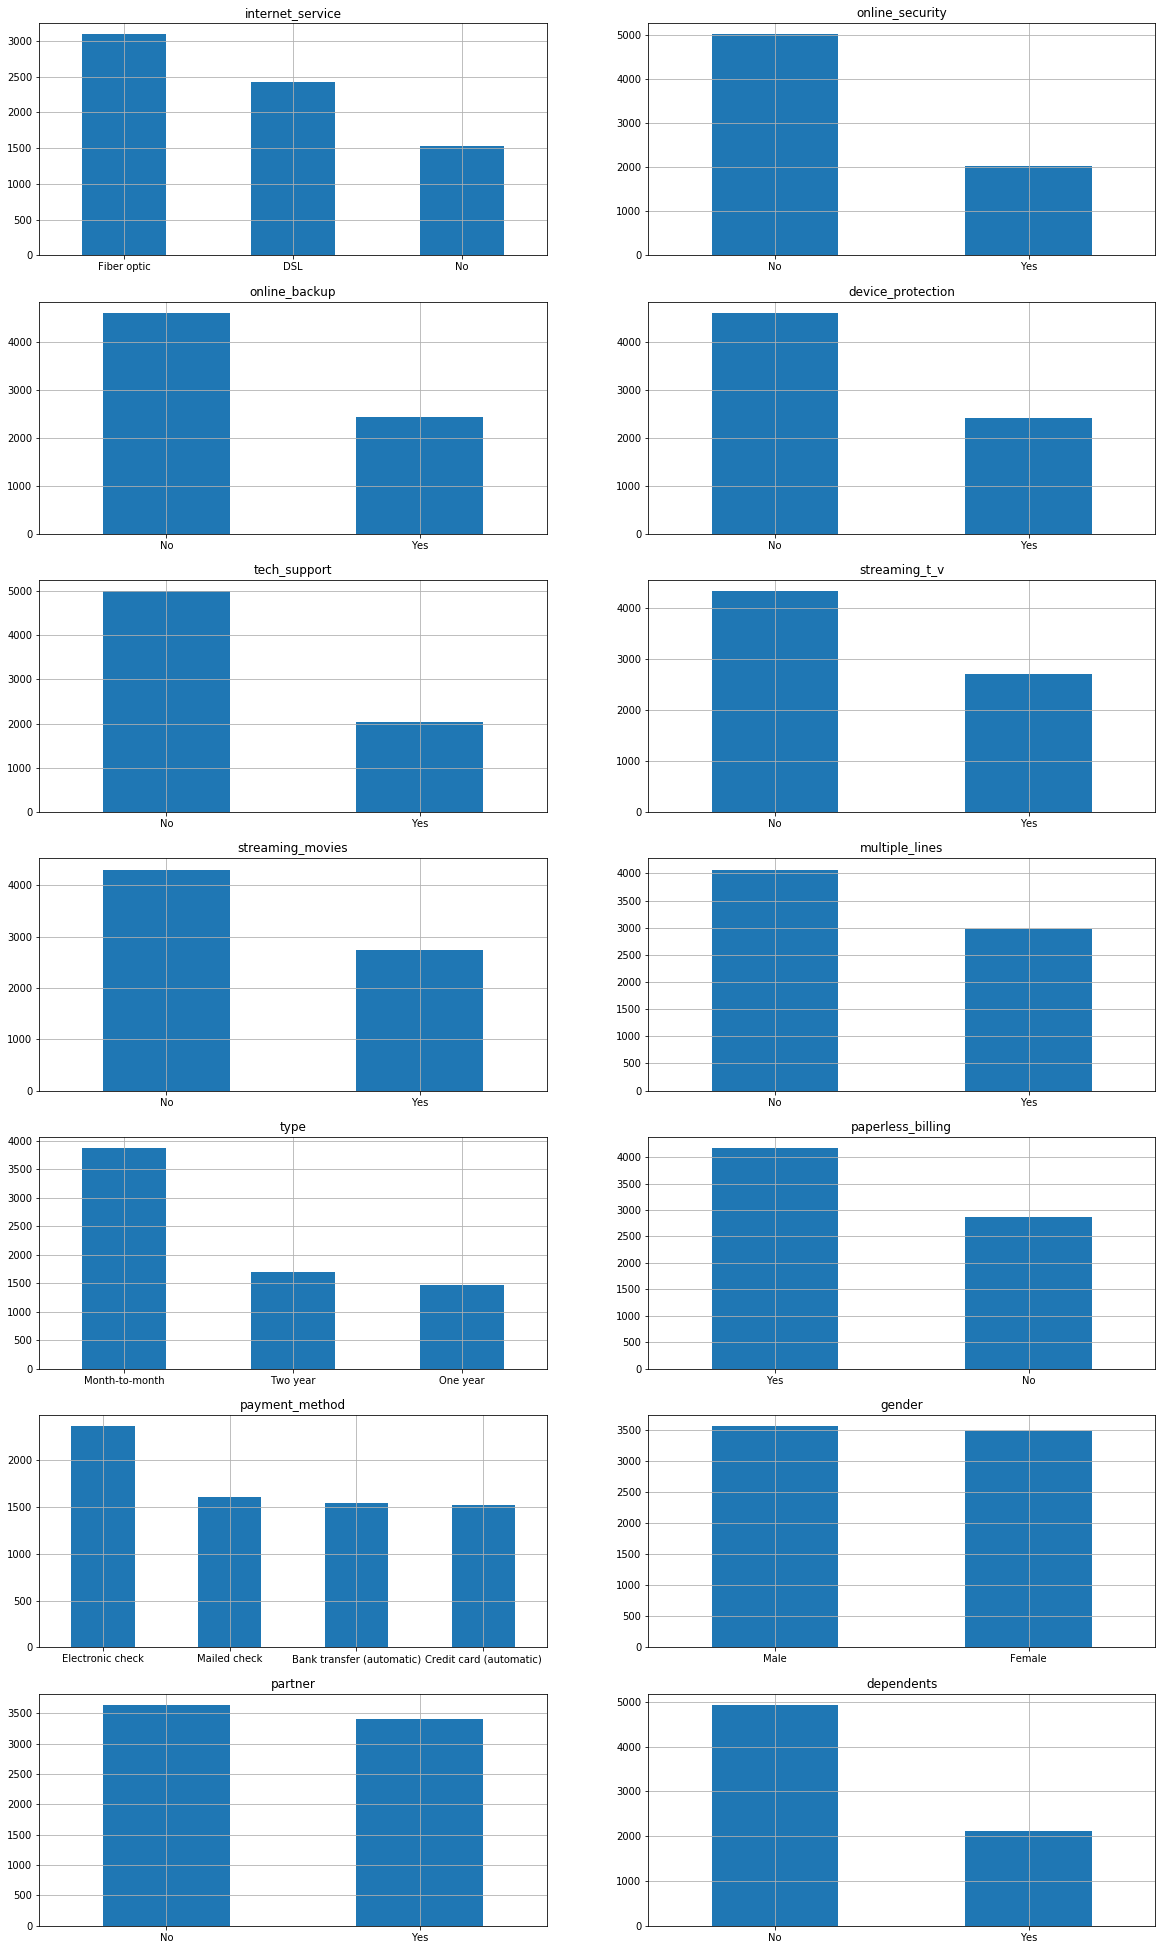

In [38]:
category_columns=data_columns+['type','paperless_billing','payment_method','gender','partner','dependents']
display(len(category_columns))
cols = 2
rows = int((len(category_columns) / cols))
j=1
plt.figure(figsize=(20, 35))

for i in category_columns:
    ax = plt.subplot(rows, cols,j)
    df_data[i].value_counts().plot(kind='bar',rot=0,grid=True, title=i, ax=ax)
    j+=1
    
plt.show()


### Вывод

1. Самый популярный способ оплаты - помесячный
2. Люди чаще предпочитают получать счета в электронном виде и оплачивать их при помощи электронного чека
3. Самый частый способ подключения - оптоволокно
4. Дополнительные услуги не пользуются популярностью у пользователей
5. У пользователей в основном нет иждивенцев



### Числовые данные

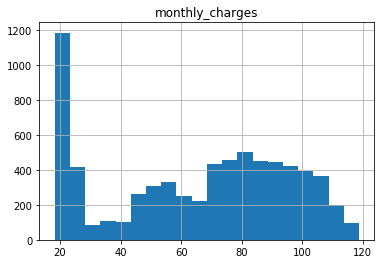

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

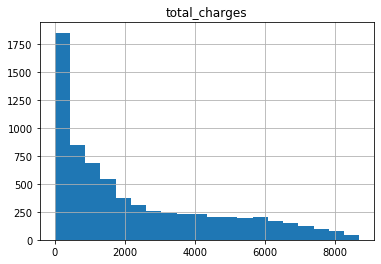

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: total_charges, dtype: float64

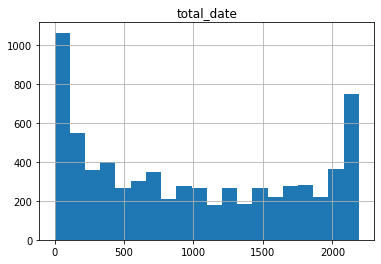

count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: total_date, dtype: float64

In [39]:
numeric_columns=['monthly_charges','total_charges','total_date']
for i in numeric_columns:
    df_data[i].hist(bins=20)
    plt.title(i)
    plt.show()
    display(df_data[i].describe())


 ### Корреляция числовых данных

In [40]:
df_data[numeric_columns].corr()

,monthly_charges,total_charges,total_date
monthly_charges,1.000000,0.651174,0.247754
total_charges,0.651174,1.000000,0.826109
total_date,0.247754,0.826109,1.000000


так как корреляция между столбцами `total_charges` и `total_date` больше 0.82 один из столбцов можно удалить. Удалим `total_charges`

In [41]:
numeric_columns

['monthly_charges', 'total_charges', 'total_date']

In [42]:
del df_data['total_charges']
numeric_columns.remove('total_charges')

### Вывод

1. Значения в столбце total_charges убывают, в то же время в столбце mnthly_charges виден пик в райне 85 - это значит, что пользователи, которые платят за тариф много на долго не остаются
2. Также у monthly_charges виден пик в районе 20, что является минимальным значением
3. Аномальных выбросов не видно
4. На графике total_date есть два пика. Первый пользователи которые пользовались услугами малое количество времени, и второй- большое количество времени
5. Найдена корреляция между столбцами `total_charges` и `total_date` которая составляет больше 0.82 один из столбцов можно удалить. Удалим `total_charges`


## Подготовка данных для моделей

Удалим ненужные для обучения столбцы связанные с временем т.к не работаем с числовым рядом, а также столбцы со временем начала и конца договора отрицательно сказываются на обучении моделей

In [43]:
df_data_model=df_data.copy()

In [44]:
 del df_data_model['begin_date'], df_data_model['end_date']

In [45]:
df_data_model

,type,paperless_billing,payment_method,monthly_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,loss,total_date
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
5575-GNVDE,One year,No,Mailed check,56.95,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,61
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,One year,Yes,Mailed check,84.80,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,0,730
2234-XADUH,One year,Yes,Credit card (automatic),103.20,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0,2191
4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,No,0,337


In [46]:
# df_data_model_CB=df_data_model.copy()

In [47]:
# df_data_model_CB

Проведем OHE (One-Hot Encoding) кодирование для того, чтобы преобразовать категоральные признаки в числовые

In [48]:
df_data_model= pd.get_dummies(df_data_model, drop_first=True)

In [49]:
df_data_model.head()

,monthly_charges,senior_citizen,loss,total_date,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,...,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_t_v_Yes,streaming_movies_Yes,multiple_lines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,0,0,31,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
5575-GNVDE,56.95,0,0,1036,1,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
3668-QPYBK,53.85,0,1,61,0,0,1,0,0,1,...,0,0,0,1,1,0,0,0,0,0
7795-CFOCW,42.30,0,0,1371,1,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
9237-HQITU,70.70,0,1,61,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [50]:
# encoder = OrdinalEncoder()
# data_ordinal = pd.DataFrame(encoder.fit_transform(df_data_model_CB),
#                             columns=df_data_model_CB.columns)

Признаки и целевой показатель

In [51]:
target = df_data_model['loss'] # Цель
display(target.shape)


(7043,)

In [52]:
# target = data_ordinal['loss'] # Цель
# display(target.shape)

In [53]:
features = df_data_model.drop(columns=['loss'], axis=1) #признаки
display(features.shape)

(7043, 21)

In [54]:
# features = data_ordinal.drop(columns=['loss'], axis=1) #признаки
# display(features.shape)

Считаем сколько в выборке 0 и 1.

In [55]:
display(df_data['loss'].value_counts())

0    5174
1    1869
Name: loss, dtype: int64

In [56]:
ratio_value_counts = df_data['loss'].value_counts()[0] /df_data['loss'].value_counts()[1]

In [57]:
display(ratio_value_counts)

2.7683253076511503

Классы несбалансированы. Отношение 1:2.77. Поэтому в моделях заложим class_weight='balanced' или проведем upsampling, т.е увеличить число объектов меньшего класса путём их многократного копирования.

Делим выборку на тренировочную и тестовую 20 %

In [58]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345) # отделим 20% данных

In [59]:
display(features_train.shape)

(5634, 21)

In [60]:
#features_train, target_train = upsample(features_train, target_train, 3)

In [61]:
# ratio = target_train[target_train == 1].count() / target_train[target_train == 0].count()
# display(ratio)

Проводим масштабирование числовых признаков

In [62]:
# scaler = StandardScaler()
# scaler.fit(features_train[numeric_columns]) 
# features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
# features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

### Вывод

1. Удалили ненужные для обучения столбцы связанные с временем т.к не работаем с числовым рядом, а также столбцы со временем начала и конца договора отрицательно сказываются на обучении моделей
2. Провели OHE (One-Hot Encoding) кодирование для того, чтобы преобразовать категоральные признаки в числовые
3. Оценили несбалансированность классов. Отношение 1:2.77. Поэтому в моделях заложим class_weight='balanced' или проведем upsampling, для увеличения числа объектов меньшего класса путём их многократного копирования.
4. Оценили влияния масштабирования на обучения моделей

## Обучение моделей

### LogisticRegression

In [63]:
#param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
param_grid={'C':np.logspace(-4, 3, 8)}

model = LogisticRegression(class_weight='balanced',random_state=12345, n_jobs=-1)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

print(search.best_params_)

predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]

{'C': 1000.0}


ROC-AUC score 0.8426620898122295


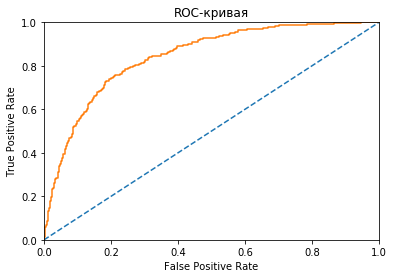

In [64]:
ROC(target_test, predicted_probalities)

### DecisionTreeClassifier

In [65]:
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    
}

model_tree = DecisionTreeClassifier(random_state=12345,class_weight='balanced')

search = GridSearchCV(model_tree, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

print(search.best_params_)

predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}


ROC-AUC score 0.8352229935702027


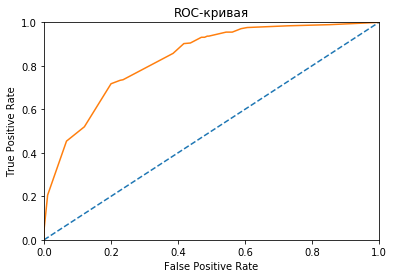

In [66]:
ROC(target_test, predicted_probalities)

### RandomForestClassifier

In [67]:
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'n_estimators': [10, 50, 100], 
}

model = RandomForestClassifier(random_state=12345,n_jobs = -1,class_weight='balanced' )

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

print(search.best_params_)

predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]


{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


ROC-AUC score 0.8582242487896098


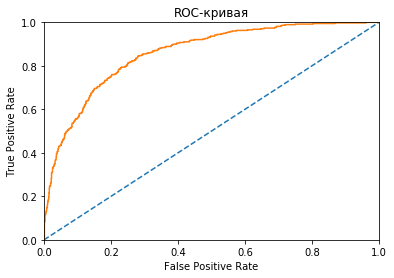

In [68]:
ROC(target_test, predicted_probalities)

### CatBoostClassifier

In [69]:
param_grid = {
    'learning_rate': [0.001, 0.1, 0.3],
    'iterations': [50, 100,200,500],
    'l2_leaf_reg': [3, 9]
    
}

model = CatBoostClassifier(random_state=12345, verbose=0, thread_count = -1)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

print(search.best_params_)

predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]

{'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


ROC-AUC score 0.9219983605297537


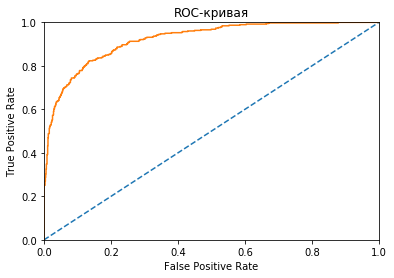

In [70]:
ROC(target_test, predicted_probalities)

In [71]:
importances = pd.DataFrame(search.best_estimator_.feature_importances_, index = features_test.columns, columns=['importances'])
importances = importances.sort_values(by='importances', ascending=False)
importances

,importances
total_date,52.084113
monthly_charges,13.264457
type_Two year,4.247110
internet_service_Fiber optic,2.655889
paperless_billing_Yes,2.318436
type_One year,2.061696
gender_Male,2.052101
payment_method_Electronic check,2.030662
dependents_Yes,1.930512
multiple_lines_Yes,1.838709


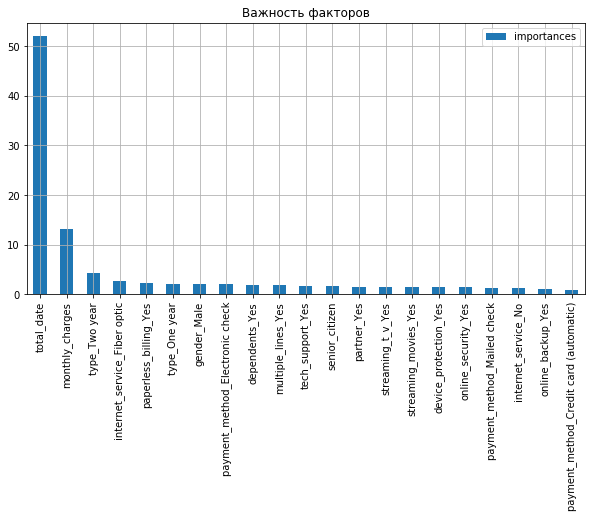

In [72]:
importances.plot(kind='bar', figsize=(10, 5), title='Важность факторов',grid=True)
plt.show()

## Выводы

Целью данной работы является оценка вероятности ухода клиента от оператора связи. Для этого провели следующие манипуляции с представленными данными:

1. Преобработка данных показала:
   1. Добавили целевой признак loss, который означает отказался клиент от услуг или нет. Если значение в столбце end_date равно "No", то значит клиент не ушел и целевой признак равен 0. Если дата ухода есть, то целевой признак равен 1.
   2. Перевели end_date и begin_date в формат даты 
   3. Заполнили пропуски 0 в столбце 'total_charges' т.к подключились в один день
   4. Пропуски в остальных категориальных столбцах скорее всего означают отсутсвие услуги, заменили на No
   5. Установили customerID в качестве индекса
   6. После предварительных расчетов добавили столбец с временем пользования услугами организации т.к. это важный параметр для точности расчета
2. Предварительные расчеты показали: 
   1. Применение в обучении моделей времени начала и конца договора отрицательно сказывается на модель,  метрика ROC-AUC score 0.9999999999999999
   2. Удаление столбцов как и предполагалась изначально приводит к максимальному росту метрики в диапазоне от 0,77 до 0,846 в зависимости от модели
   3. Использование различных видов кодирования не меняет в принципе изменение метрики, она так и находится от 0,77 до 0,846 в зависимости от модели
   4. Использование масштабирования и балансировка классов не дает существенного прироста в метрике
   5. Учитывая, что мы удаляем столбцы со временем начала и конца договоров, а время пользования услугами существенно для организации введем метрику связанную с разностью начала и конца договора, например месяц или количество дней т.к. минимальное количество пользования услугами-месяц.
3. Анализ категориальных данных показал:
   1. Самый популярный способ оплаты - помесячный
   2. Люди чаще предпочитают получать счета в электронном виде и оплачивать их при помощи электронного чека
   3. Самый частый способ подключения - оптоволокно
   4. Дополнительные услуги не пользуются популярностью у пользователей
   5. У пользователей в основном нет иждивенцев
4. Анализ числовых данных показал:
   1. Значения в столбце total_charges убывают, в то же время в столбце mnthly_charges виден пик в райне 85 - это значит, что пользователи, которые платят за тариф много на долго не остаются
   2. Также у monthly_charges виден пик в районе 20, что является минимальным значением
   3. Аномальных выбросов не видно
   4. На графике total_date есть два пика. Первый- пользователи которые пользовались услугами малое количество времени, и второй- большое количество времени
   5. Найдена корреляция между столбцами `total_charges` и `total_date` которая составляет больше 0.82 один из столбцов можно удалить. Удалим `total_charges`
5. Подготовка данных для моделей:
   1. Удалили ненужные для обучения столбцы связанные с временем т.к не работаем с числовым рядом, а также столбцы со временем начала и конца договора отрицательно сказываются на обучении моделей
   2. Провели OHE (One-Hot Encoding) кодирование для того, чтобы преобразовать категоральные признаки в числовые
   3. Оценили несбалансированность классов. Отношение 1:2.77. Поэтому в моделях заложим class_weight='balanced' или проведем upsampling, для увеличения числа объектов меньшего класса путём их многократного копирования.
   4. Оценили влияния масштабирования на обучения моделей
6. Обучение моделей:
   1. Обучили 4 модели LogisticRegression, DecisionTreeClassifier, RandomForestClassifier и CatBoostClassifier
   2. Лучший результат показала модель CatBoostClassifier со значением метрики ROC-AUC в 0.92
   
     

